### Generate k-means datasets for practice
### Bill Nicholson
### nicholdw@ucmail.uc.edu

In [1]:
from sklearn.cluster import KMeans
import json
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns
import shutil
from collections import OrderedDict
import colorsys

In [2]:
def log(msg, fileName, mode):
    # mode: 'w' = write, 'a+' = append
    with open('fileName.txt', 'w') as f:
        print('Filename:', filename, file=f)
        f.close()

In [3]:
# https://stackoverflow.com/questions/470690/how-to-automatically-generate-n-distinct-colors/30881059#30881059
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [4]:
def computeEuclideanDistance(p1, p2):
    euclideanDistance = sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    return euclideanDistance

In [5]:
def targetClusterToString(targetCluster):
    toString = ""
    delimiter = ""
    for key in targetCluster.keys():
        toString += delimiter + key + ":" + str(targetCluster[key])
        delimiter = "-"
    return "(" + toString + ")"

In [6]:
def generateDatasets(practiceDatasets):
    for file in practiceDatasets["files"]:
        mode = "w"
        mySeed = 42                # Default
        myDistribution = "normal"  # Default
        logFile = None
        logFileName = None
        mySigma = 100            # Wild guess
        #print("seed =", file["seed"])
        if file.get("seed") != None: mySeed = int(file["seed"])
        if file.get("sigma") != None: mySigma = int(file["sigma"])
        if file.get("totalpoints") != None: numberOfRows = int(file["totalpoints"])
        # Gaussian doesn't work so don't use it
        #if file.get("distribution") != None: myDistribution = file["distribution"]
        random.seed(mySeed)
        columnsToCluster = OrderedDict()
        optimalClusters = int(file["optimal clusters"])
        targetClusters = []  # Will be populated as a list of dictionaries. Each sub dictionary is a point on the graph (x,y)
        fileName = file["fileName"]
        logFileHandle = open(fileName + '.txt', 'w') 
        print("Creating", fileName+".csv", "optimal clusters = ", optimalClusters, file = logFileHandle)
        print("seed =", mySeed, file = logFileHandle)
        print("distribution =", myDistribution, file = logFileHandle)
        print("total points =", numberOfRows, file = logFileHandle)
        if myDistribution == "gaussian": print("sigma =", mySigma, file = logFileHandle)
        headerRow = [str(x) for x in file["columns"].keys()]
        headerRow = ",".join(headerRow) + "," + "Target Centroid"
        print("Header row = ", headerRow, file = logFileHandle)
        with open(fileName + ".csv", mode) as f:
            if mode == "w":
                f.write(headerRow)
                f.write("\n")
            for column in file["columns"]:
                if column in file["columns to cluster"]:
                    columnsToCluster[column] = file["columns"][column]
            print("Columns to cluster:", columnsToCluster, file = logFileHandle)
            if columnsToCluster == []:
                raise Exception("No columns to cluster were found in the meta data.")
            for i in range(0, int(optimalClusters)):
                # we need a randomly generated (x, y) for the cluster.
                # x and y are the two columns we are operating on as specified in "columns to cluster" in the meta data file
                # for that we need the max/min for x and y
                point = OrderedDict()

                for key in columnsToCluster.keys():
                    max = int(columnsToCluster[key]["max"])
                    min = int(columnsToCluster[key]["min"])
                    # We need some random value in the range (max,min) that is sufficiently far enough away from the other clusters we are generating here
                    # Nudge the points away from the edges
                    featureRange = max - min
                    featureMiddle = min + (featureRange / 2)
                    #point[key] = featureMiddle + int(random.uniform(-.3, .3) * featureRange)
                    upper = int(min + (min * .23))
                    lower = int(max - (max * .23))
                    point[key] = random.randint(upper, lower)
                    #print("key =", key, "max = ", max, "min =", min, "featureRange =", featureRange, "featureMiddle =", featureMiddle)
                    #print("upper =", upper, "lower =", lower, "co-ordinate =", point[key]) 
                targetClusters.append(point)

            print("Target clusters computed to be:", file = logFileHandle)
            for targetCluster in targetClusters:
                print(targetCluster, file = logFileHandle)
            for rowNumber in range(0, int(numberOfRows/optimalClusters)):
                for i in range(0, len(targetClusters)):
                    row = OrderedDict()
                    for columnName in file["columns"]:
                        # column is a dictionary
                        #print(column, ":", file["columns"][column])
                        column = file["columns"][columnName]
                        max = int(column["max"])
                        min = int(column["min"])
                        increment= column["increment"]
                        value = random.randint(min, max)
                        row[columnName] = str(value)
                    # Now we have a randomly generated row but we do not know if it's near any of our centroid points
                    #print("before:", row)
                    newValues = dict()
                    randomTargetCluster = random.choice(targetClusters)
                    row["Target Cluster"] = targetClusterToString(randomTargetCluster)
                    for column in columnsToCluster.keys():
                        #x = row[column]
                        newValues[column] = randomTargetCluster[column]
                    for key in newValues.keys():
                        if myDistribution == "normal":
                            increment = (newValues[key] * random.uniform(-.2, .2))
                            row[key] = int(newValues[key] + increment)
                        elif myDistribution == "gaussian":
                            mu = 5  #randomTargetCluster[key]
                            row[key] = newValues[key] + (int(random.gauss(mu, sigma))) # * random.uniform(-.2, .2)))                            
                        if random.random() > .90:
                            increment = int(row[key] * random.random()) * random.randint(-1, 1)
                            tmp = row[key] + increment
                            #print("row =", row, "\n  key =", key, "row[key] =", row[key], "increment =", increment, tmp =", tmp)
                            if tmp >= int(file["columns"][key]["min"]) and tmp <= int(file["columns"][key]["max"]):
                                row[key] = tmp
                                #print("Adding ", increment, "to get", row[key] + tmp)
                    #print("after:", row)
                    rowString = ""
                    comma = ""
                    for key in row.keys():
                        rowString += comma + str(row[key])
                        comma = ","
                    f.write(rowString)
                    f.write("\n")
            f.close()
    logFileHandle.close()
    return fileName

### Test one of the data files we generated 

In [7]:
def testOurGeneratedDataFile(fileName):
    myDF = pd.read_csv(fileName + ".csv")
    # drop all the columns except the two we are fitting to
    myDF = myDF[["square feet", "annual property tax"]]
    #myDF.drop(["bathrooms", "lot size", "Target Centroid"], axis=1, inplace=True)
    logFileHandle = open(fileName + '.txt', 'a+') 
    #print(myDF.head())
    inertias = []
    myRange = range(1,11)
    for i in myRange:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(myDF)
        inertias.append(kmeans.inertia_)

    plt.plot(myRange, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.rcParams['figure.figsize'] = [18, 18]  # I don't know why this works but it does seem to pleasingly resize the subplots
    plt.show()
    
    # Scatter plot of the DataFrame overlaid with the scatter plot of the centroids (K-means)
    # We will guess there are three clusters: that should match the "optimal clusters" value in the meat data file
    kmeans = KMeans(n_clusters = 3)
    #print(myDF.describe())
    kmeans.fit(myDF)

    fig, ax = plt.subplots()
    ax.set_ylabel("Property Tax")
    ax.set_xlabel("Square Feet")
    plt.scatter(myDF['square feet'], myDF['annual property tax'], c=kmeans.labels_)
    centroids = kmeans.cluster_centers_
    #print("Data type of centroid data:", type(centroids))
    print("Actual shape of centroid data:", centroids.shape, file = logFileHandle)
    print("Actual centroids computed by fit method:", file = logFileHandle)
    for centroid in centroids:
        print(type(centroid), centroid, file = logFileHandle)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 160, c=get_colors(len(centroids))) # color = myColors)
    plt.show()
    # Save a a copy of our definitive centroids for classification.
    happyCentroids = kmeans.cluster_centers_    
    logFileHandle.close()
    

    # Plot all the points in the same color just to get a feel for the points without classificaiton
    fig, ax = plt.subplots()
    ax.set_ylabel("Property Tax")
    ax.set_xlabel("Square Feet")
    plt.scatter(myDF['square feet'], myDF['annual property tax'])
    plt.show()
    
    # Would be interesting: plot points in each classifications in a different color using the original centroids in the CSV file.

C:\Users\nicholdw\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


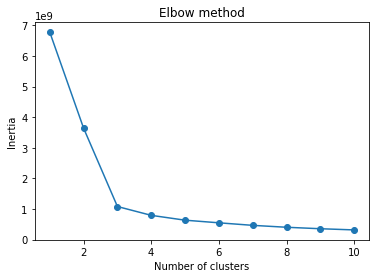

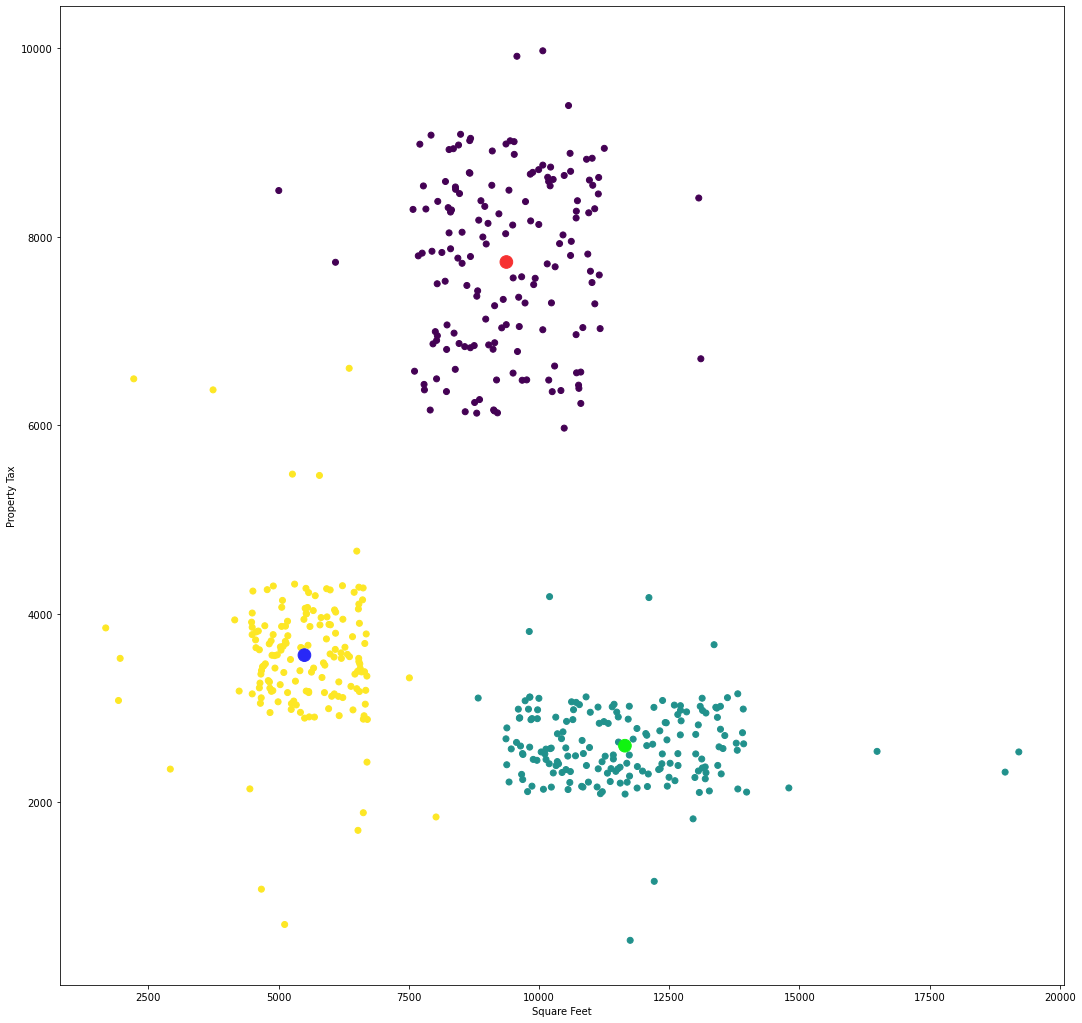

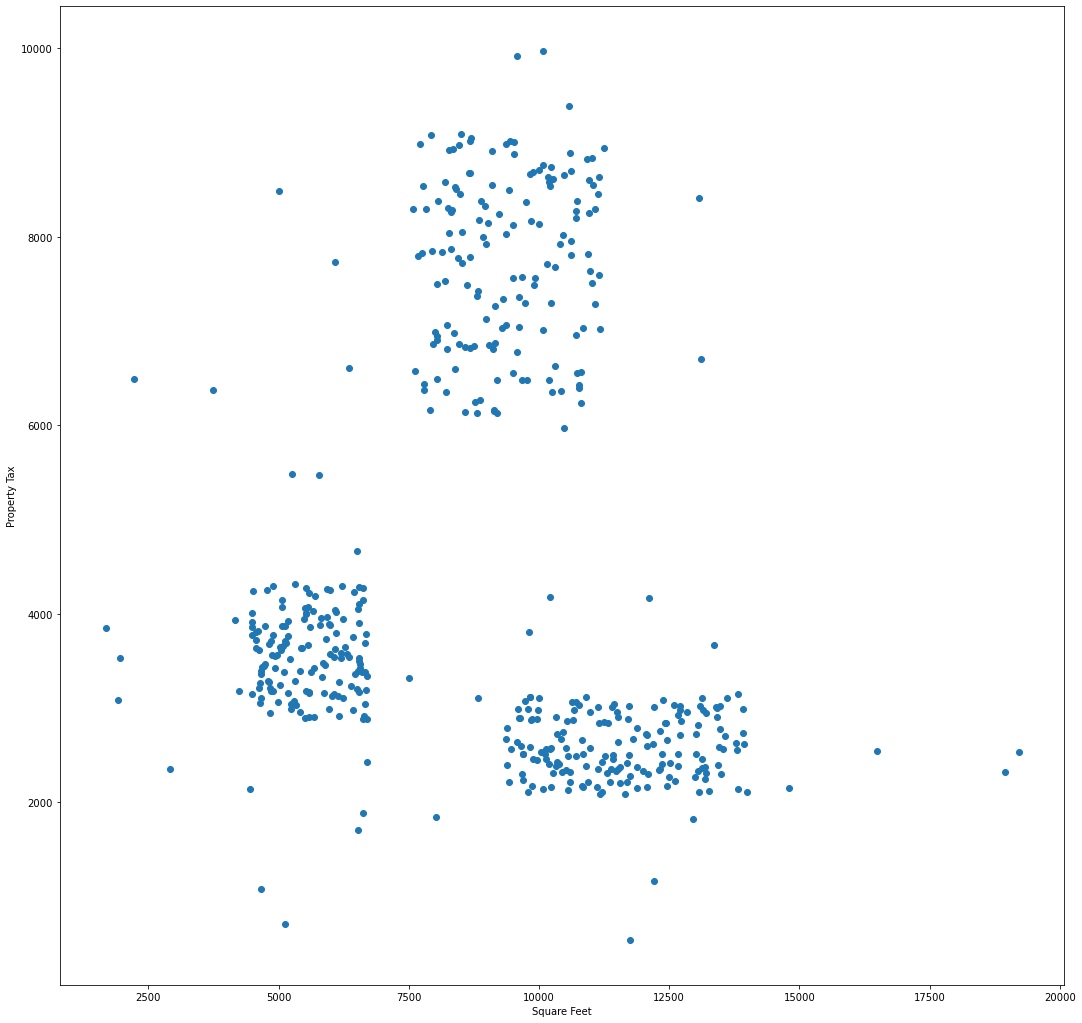

In [8]:
if __name__ == "__main__":
    fileHandle = open("PracticeDatasetsMetaData.json")
    practiceDatasets = json.load(fileHandle)
    #print(practiceDatasets)
    generateDatasets(practiceDatasets)
    testOurGeneratedDataFile("houses")